In [1]:
import numpy as np
from matplotlib import cm
from matplotlib import colors
import matplotlib.pyplot as plt
from halotools.sim_manager import CachedHaloCatalog
from halotools.mock_observables import wp
from halotools.empirical_models import PrebuiltHodModelFactory,  Zheng07Cens, Zheng07Sats, TrivialPhaseSpace,NFWPhaseSpace, HodModelFactory
from halotools.mock_observables import return_xyz_formatted_array
from astropy.cosmology import FlatLambdaCDM
from tabcorr import TabCorr
import emcee
import warnings
warnings.filterwarnings("ignore")
import scipy.constants as sc
import scipy.stats as ss

In [2]:
cosmo = FlatLambdaCDM(H0=67.77, Om0=0.307115) # smdpl
param = 'vmax'
threshold=19
dname = '21'
Lbox = 400

In [3]:
halocat = CachedHaloCatalog(fname = '/Users/lmezini/.astropy/cache/halotools/halo_catalogs/SMDPL/rockstar/smdpl.dat.smdpl2.hdf5',update_cached_fname = True)


In [4]:
mvir = halocat.halo_table['halo_mvir']
rvir = halocat.halo_table['halo_rvir']
vmax = halocat.halo_table['halo_vmax']
G = sc.gravitational_constant
vvir = (G*mvir/rvir)**0.5


In [5]:
print(vvir[0],mvir[0],vmax[0])
print(np.log10(vvir[0]),np.log10(vmax[0]),np.log10(mvir[0]))

216.77905 1714800000000000.0 1980.97
2.3360174 3.2968779 15.234214


In [5]:
m, b, r, p, se = ss.linregress(np.log10(vmax), np.log10(mvir))
m = m+0.04
m,b

(3.1069839419403174, 5.015822745222037)

In [6]:
vmax_ml = np.log10(vmax)*(m)+(b)

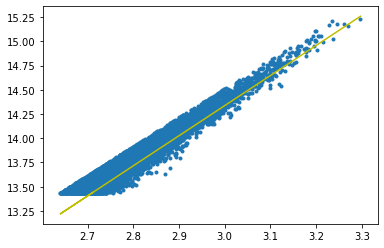

In [98]:
plt.scatter(np.log10(vmax[0:10_000]),np.log10(mvir[0:10_000]),marker='.')
plt.plot(np.log10(vmax[0:10_000]),np.log10(vmax[0:10_000])*(m)+(b),c='y')
#plt.yscale('log')
#plt.xscale('log')

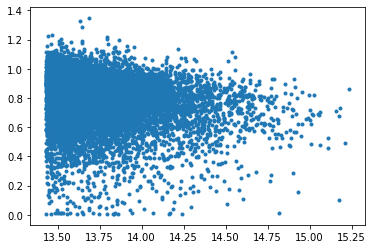

In [25]:
plt.scatter(np.log10(mvir[0:10_000]),np.log10(halocat.halo_table['halo_nfw_conc'])[0:10_000],marker='.')
#plt.plot(np.log10(vmax[0:10_000]),np.log10(vmax[0:10_000])*(m)+(b),c='y')

In [7]:
m2, b2, r2, p2, se2 = ss.linregress(vmax_ml, np.log10(vmax))
m2,b2

(0.32185554556087204, -1.6143682855344816)

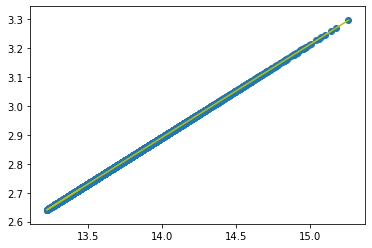

In [10]:
plt.scatter(vmax_ml[0:10000],np.log10(mvir[0:10000]))
plt.plot(vmax_ml[0:10000],vmax_ml[0:10000]*(m2)+(b2),c='y')
#plt.yscale('log')
#plt.xscale('log')

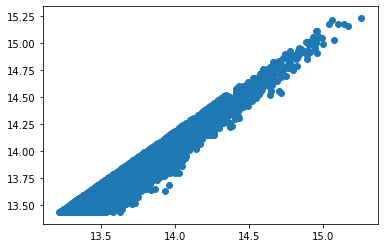

In [29]:
plt.scatter((vmax_ml[0:10000]),np.log10(mvir[0:10000]))

In [10]:
##CONVERT FROM VMAX TO MASS LIKE
#print(10**(np.log10(100)*(m)+(b)),halocat.particle_mass)
#convert Vmax param vals to masslike
        #logVmaxMin, LogVmax0, LogVmax1

vals = [2.156,0.203,3.186,1.73,2.488]
vals[0]=vals[0]*(m)+(b)
vals[3]=vals[3]*(m)+(b)
vals[4]=vals[4]*(m)+(b)
vals[1]=vals[1]*m #sigma
vals[2]=vals[2]/m #alpha
print(vals)

##CONVERT FROM MVIR TO VMAX


vals = [11.71538396,  0.63156037,  1.02565892, 10.39502053, 12.74709736]
vals[0]=vals[0]*(m2)+(b2)
vals[3]=vals[3]*(m2)+(b2)
vals[4]=vals[4]*(m2)+(b2)
vals[1]=vals[1]*m2 #sigma
vals[2]=vals[2]/m2 #alpha
print(vals)

vals = [0.72413758, 1.11337677, 0.00502741, 1.19743258, 0.00591006]
vals[0]=vals[0]*(m2)
vals[3]=vals[3]*(m2)
vals[4]=vals[4]*(m2)
vals[1]=vals[1]*m2 #sigma
vals[2]=vals[2]/m2 #alpha
print(vals)

vals = [0.12913378, 0.25423182, 0.1345354, 0.10644515, 0.26886441]
vals[0]=vals[0]*(m2)
vals[3]=vals[3]*(m2)
vals[4]=vals[4]*(m2)
vals[1]=vals[1]*m2 #sigma
vals[2]=vals[2]/m2 #alpha
print(vals)

[11.714480124045362, 0.6307177402138845, 1.025431756177773, 10.390904964778786, 12.745998792769546]
[2.156293010366408, 0.20327120744097618, 3.1867057571205297, 1.7313267182651337, 2.48835568958587]
[0.2330676958720296, 0.35834648772315153, 0.015620081957075288, 0.3854003163082626, 0.0019021855855974874]
[0.041562423212237624, 0.08182592112503342, 0.4179993225394202, 0.034259961825558856, 0.08653550136245197]


In [127]:
cens_occ_model = Zheng07Cens(prim_haloprop_key = 'vmax_ml',threshold=threshold)
cens_prof_model = TrivialPhaseSpace()
sats_occ_model =  Zheng07Sats(prim_haloprop_key = 'vmax_ml',threshold=threshold)#, modulate_with_cenocc=True,threshold=threshold)
sats_prof_model = NFWPhaseSpace()
model_instance = HodModelFactory(centrals_occupation = cens_occ_model, centrals_profile = cens_prof_model, 
                                 satellites_occupation = sats_occ_model, satellites_profile = sats_prof_model)
model_instance.populate_mock(halocat)

mean_ncen_vml = cens_occ_model.mean_occupation(prim_haloprop=halocat.halo_table['vmax_ml'])
mean_nsat_vml = sats_occ_model.mean_occupation(prim_haloprop=halocat.halo_table['vmax_ml'])

In [53]:
cens_occ_model = Zheng07Cens(prim_haloprop_key = 'halo_mvir',threshold=threshold)
cens_prof_model = TrivialPhaseSpace()
sats_occ_model =  Zheng07Sats(prim_haloprop_key = 'halo_mvir',threshold=threshold)#, modulate_with_cenocc=True,threshold=threshold)
sats_prof_model = NFWPhaseSpace()
model_instance = HodModelFactory(centrals_occupation = cens_occ_model, centrals_profile = cens_prof_model, 
                                 satellites_occupation = sats_occ_model, satellites_profile = sats_prof_model)
model_instance.populate_mock(halocat)

mean_ncen_v = cens_occ_model.mean_occupation(table=halocat.halo_table)
mean_nsat_v = sats_occ_model.mean_occupation(table=halocat.halo_table)

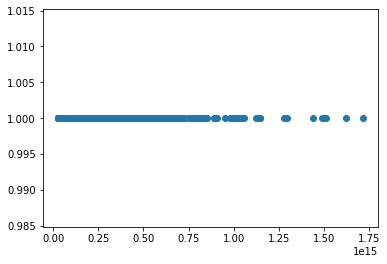

In [59]:
plt.scatter(mvir[0:10000],mean_ncen_v[0:10000])

(0.1, 100)

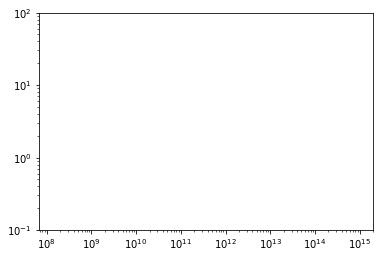

In [129]:
#plt.semilogy(vmax_ml[0:int(0.99e5)],mean_nsat[0:int(0.99e5)],ls='', marker='.')
plt.semilogy(vmax_ml[0:int(0.99e5)],mean_nsat_v[0:int(0.99e5)],ls='', marker='.')
plt.xscale('log')
plt.ylim(0.1,100)

Find Vmax cut off for TabCorr

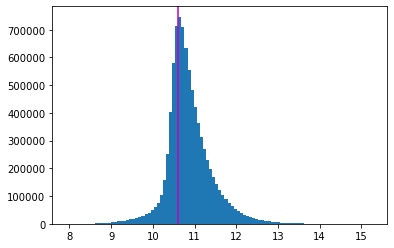

In [71]:
bins = np.linspace(np.min(vmax_ml),np.max(vmax_ml),100)
counts,bins,patches = plt.hist(vmax_ml,bins=bins)
plt.axvline(bins[np.where(counts == np.max(counts))],c='m')
#plt.xlim(10,11)

In [72]:
np.where(counts == np.max(counts))
10**(bins[np.where(counts == np.max(counts))])#np.where(counts == np.max(counts))])


array([4.09236466e+10])

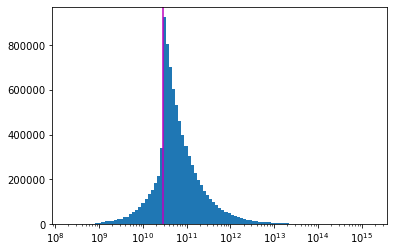

In [80]:
bins = np.logspace(np.min(np.log10(mvir)),np.max(np.log10(mvir)),100)
counts,bins,patches = plt.hist(mvir,bins=bins)
plt.xscale('log')
plt.axvline(bins[np.where(counts == np.max(counts))],c='m')

In [81]:
np.where(counts == np.max(counts))
(bins[np.where(counts == np.max(counts))])

array([2.89014345e+10])

[3.52589643e+10]


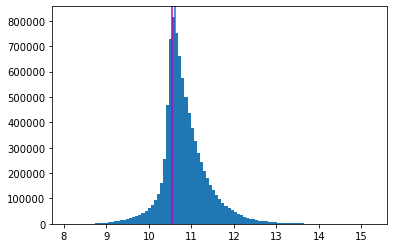

In [73]:
a = 0.6
bins = np.linspace(np.min((1-a)*np.log10(mvir)+a*vmax_ml),np.max((1-a)*np.log10(mvir)+a*vmax_ml),100)
counts,bins,patches = plt.hist((1-a)*np.log10(mvir)+a*vmax_ml,bins=bins)
plt.axvline(bins[np.where(counts == np.max(counts))],c='m')
plt.axvline(10.61197433)
print(10**(bins[np.where(counts == np.max(counts))]))